## Importing Libraries


In [1]:
%pip install pyspark

     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 198 kB 43.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=d7348cb6d4d7302b5e31311a791ccbaaa47711b6c8d7869c5c3bbb6036a53c9f
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Start spark session

In [ ]:
spark = SparkSession.builder.appName('crop-recommend').getOrCreate()
data = spark.read.csv('Crop_recommendation.csv', header = True, inferSchema = True)
data.printSchema()

## Show dataset

In [5]:
data.toPandas().head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
data.show()

+---+---+---+-----------+-----------------+------------------+------------------+-----+
|  N|  P|  K|temperature|         humidity|                ph|          rainfall|label|
+---+---+---+-----------+-----------------+------------------+------------------+-----+
| 90| 42| 43|20.87974371|      82.00274423| 6.502985292000001|       202.9355362| rice|
| 85| 58| 41|21.77046169|      80.31964408|       7.038096361|       226.6555374| rice|
| 60| 55| 44|23.00445915|       82.3207629|       7.840207144|       263.9642476| rice|
| 74| 35| 40|26.49109635|      80.15836264|       6.980400905|       242.8640342| rice|
| 78| 42| 42|20.13017482|      81.60487287|       7.628472891|       262.7173405| rice|
| 69| 37| 42|23.05804872|      83.37011772|       7.073453503|       251.0549998| rice|
| 69| 55| 38|22.70883798|      82.63941394|        5.70080568|       271.3248604| rice|
| 94| 53| 40|20.27774362|      82.89408619| 5.718627177999999|       241.9741949| rice|
| 89| 54| 38|24.51588066|83.5352

## Show labels

In [7]:
data.groupby('label').count().toPandas()

,label,count
0,chickpea,100
1,mungbean,100
2,orange,100
3,papaya,100
4,pigeonpeas,100
5,cotton,100
6,apple,100
7,mango,100
8,jute,100
9,grapes,100


## Checking for null values

In [8]:
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+---+---+---+-----------+--------+---+--------+-----+
|  N|  P|  K|temperature|humidity| ph|rainfall|label|
+---+---+---+-----------+--------+---+--------+-----+
|  0|  0|  0|          0|       0|  0|       0|    0|
+---+---+---+-----------+--------+---+--------+-----+



## Show ranges of all parameters

In [9]:
data.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117


## Show parameters ranges in graphs

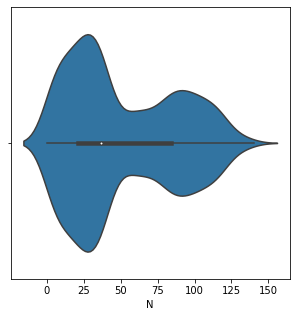

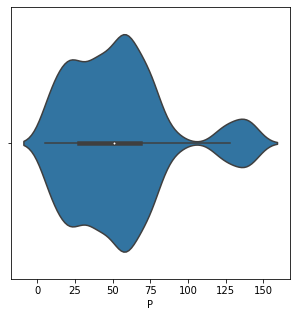

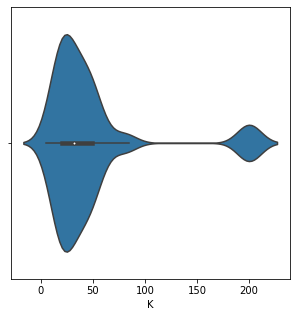

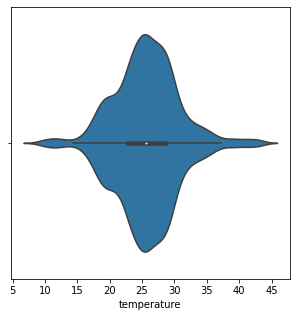

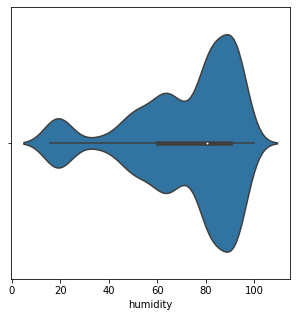

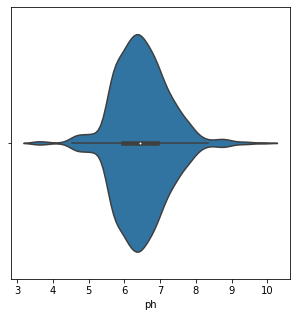

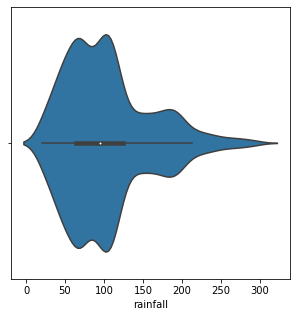

In [10]:
required_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

warnings.filterwarnings("ignore")
for col in required_features:
  plt.figure(figsize=(5,5))
  sns.violinplot(data.toPandas()[col], warning=False)

## Combines a given list of columns into a single vector column

In [11]:
assembler = VectorAssembler(inputCols=required_features, outputCol='feature')

transformed_data = assembler.transform(data)
transformed_data.show()

+---+---+---+-----------+-----------------+------------------+------------------+-----+--------------------+
|  N|  P|  K|temperature|         humidity|                ph|          rainfall|label|             feature|
+---+---+---+-----------+-----------------+------------------+------------------+-----+--------------------+
| 90| 42| 43|20.87974371|      82.00274423| 6.502985292000001|       202.9355362| rice|[90.0,42.0,43.0,2...|
| 85| 58| 41|21.77046169|      80.31964408|       7.038096361|       226.6555374| rice|[85.0,58.0,41.0,2...|
| 60| 55| 44|23.00445915|       82.3207629|       7.840207144|       263.9642476| rice|[60.0,55.0,44.0,2...|
| 74| 35| 40|26.49109635|      80.15836264|       6.980400905|       242.8640342| rice|[74.0,35.0,40.0,2...|
| 78| 42| 42|20.13017482|      81.60487287|       7.628472891|       262.7173405| rice|[78.0,42.0,42.0,2...|
| 69| 37| 42|23.05804872|      83.37011772|       7.073453503|       251.0549998| rice|[69.0,37.0,42.0,2...|
| 69| 55| 38|22.708

In [12]:
indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
indexed = indexer.fit(transformed_data).transform(transformed_data)
indexed.show()

+---+---+---+-----------+-----------------+------------------+------------------+-----+--------------------+----------+
|  N|  P|  K|temperature|         humidity|                ph|          rainfall|label|             feature|labelIndex|
+---+---+---+-----------+-----------------+------------------+------------------+-----+--------------------+----------+
| 90| 42| 43|20.87974371|      82.00274423| 6.502985292000001|       202.9355362| rice|[90.0,42.0,43.0,2...|      20.0|
| 85| 58| 41|21.77046169|      80.31964408|       7.038096361|       226.6555374| rice|[85.0,58.0,41.0,2...|      20.0|
| 60| 55| 44|23.00445915|       82.3207629|       7.840207144|       263.9642476| rice|[60.0,55.0,44.0,2...|      20.0|
| 74| 35| 40|26.49109635|      80.15836264|       6.980400905|       242.8640342| rice|[74.0,35.0,40.0,2...|      20.0|
| 78| 42| 42|20.13017482|      81.60487287|       7.628472891|       262.7173405| rice|[78.0,42.0,42.0,2...|      20.0|
| 69| 37| 42|23.05804872|      83.370117

## Training and splits data

In [13]:
(training_data, test_data) = indexed.randomSplit([0.8,0.2], seed =2020)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 1756
Test Dataset Count: 444


In [14]:
rf_model = RandomForestClassifier(labelCol='labelIndex', 
                            featuresCol='feature',
                            maxDepth=7)

## Fitting model

In [15]:
model = rf_model.fit(training_data)
rf_predictions = model.transform(test_data)

## Evalute model

In [16]:
rf_predictions.show()

+---+---+---+-----------+-----------+------------------+------------------+-----------+--------------------+----------+--------------------+--------------------+----------+
|  N|  P|  K|temperature|   humidity|                ph|          rainfall|      label|             feature|labelIndex|       rawPrediction|         probability|prediction|
+---+---+---+-----------+-----------+------------------+------------------+-----------+--------------------+----------+--------------------+--------------------+----------+
|  0| 23| 15|22.56664172|93.37488907|       7.598729065|       109.8585753|     orange|[0.0,23.0,15.0,22...|      16.0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|      16.0|
|  0| 29| 32|28.05912437| 98.3670985|       5.868255858|171.65163959999995|    coconut|[0.0,29.0,32.0,28...|       4.0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       4.0|
|  0| 55| 25|28.17489437| 43.6672299|       4.524171562|       45.78172762|  mothbeans|[0.0,55.0,25.0,28...|      13.0|[0.0,0.0,0.60456

In [17]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'labelIndex', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(rf_predictions))

Random Forest classifier Accuracy: 0.9819819819819819


## Create a new dataframe

In [18]:
new_data = spark.createDataFrame([((20, 30, 10, 15.0, 90.0, 7.5, 100.0))], schema='N integer, P integer, K integer, temperature double, humidity double, ph double, rainfall double')

In [19]:
new_data.show()

+---+---+---+-----------+--------+---+--------+
|  N|  P|  K|temperature|humidity| ph|rainfall|
+---+---+---+-----------+--------+---+--------+
| 20| 30| 10|       15.0|    90.0|7.5|   100.0|
+---+---+---+-----------+--------+---+--------+



In [20]:
new_transformed_data = assembler.transform(new_data)
new_transformed_data.show()

+---+---+---+-----------+--------+---+--------+--------------------+
|  N|  P|  K|temperature|humidity| ph|rainfall|             feature|
+---+---+---+-----------+--------+---+--------+--------------------+
| 20| 30| 10|       15.0|    90.0|7.5|   100.0|[20.0,30.0,10.0,1...|
+---+---+---+-----------+--------+---+--------+--------------------+



In [21]:
pred = model.transform(new_transformed_data)

## Convert numarical data to string using index to string

In [22]:
converter = IndexToString(inputCol="prediction", outputCol="label", labels=['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 
                                                                           'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 
                                                                           'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 
                                                                           'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon'])
converted = converter.transform(pred)
converted.show()

+---+---+---+-----------+--------+---+--------+--------------------+--------------------+--------------------+----------+------+
|  N|  P|  K|temperature|humidity| ph|rainfall|             feature|       rawPrediction|         probability|prediction| label|
+---+---+---+-----------+--------+---+--------+--------------------+--------------------+--------------------+----------+------+
| 20| 30| 10|       15.0|    90.0|7.5|   100.0|[20.0,30.0,10.0,1...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|      16.0|orange|
+---+---+---+-----------+--------+---+--------+--------------------+--------------------+--------------------+----------+------+



In [25]:
model.save("model")

In [26]:
new_model = RandomForestClassificationModel.load("model")

In [27]:
new_data = spark.createDataFrame([((30, 40, 60, 40.0, 80.0, 6.5, 202.0))], schema='N integer, P integer, K integer, temperature double, humidity double, ph double, rainfall double')

In [28]:
new_transformed_data = assembler.transform(new_data)
new_transformed_data.show()

+---+---+---+-----------+--------+---+--------+--------------------+
|  N|  P|  K|temperature|humidity| ph|rainfall|             feature|
+---+---+---+-----------+--------+---+--------+--------------------+
| 30| 40| 60|       40.0|    80.0|6.5|   202.0|[30.0,40.0,60.0,4...|
+---+---+---+-----------+--------+---+--------+--------------------+



In [29]:
pred = new_model.transform(new_transformed_data)

In [30]:
converter = IndexToString(inputCol="prediction", outputCol="label", labels=['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 
                                                                           'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 
                                                                           'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 
                                                                           'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon'])
converted = converter.transform(pred)
converted.show()

+---+---+---+-----------+--------+---+--------+--------------------+--------------------+--------------------+----------+------+
|  N|  P|  K|temperature|humidity| ph|rainfall|             feature|       rawPrediction|         probability|prediction| label|
+---+---+---+-----------+--------+---+--------+--------------------+--------------------+--------------------+----------+------+
| 30| 40| 60|       40.0|    80.0|6.5|   202.0|[30.0,40.0,60.0,4...|[0.0,2.0,0.0,1.0,...|[0.0,0.1,0.0,0.05...|      17.0|papaya|
+---+---+---+-----------+--------+---+--------+--------------------+--------------------+--------------------+----------+------+

